# Модели ResNet (Residual Networks)

## Импорт библиотек

In [1]:
import torch
import torch.nn as nn

## Основные блоки ResNet

In [16]:
# слои для дальнейшего построения блоков

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = (3,3),
        stride=stride,
        padding=1,
        bias=False
    )

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = (1, 1),
        stride = stride,
        bias=False
    )

### BasicBlock

In [21]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.con1(x)
        out = self.bn1(out)
        out = self.act(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        
        return out

### Bottleneck

In [35]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1(in_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = conv1x1(out_channels, out_channels*self.expansion)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.act = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        
        return out

## ResNet

In [36]:
class ResNet(nn.Module):

    cfgs = {
        'resnet18':(BasicBlock, [2,2,2,2]),
        'resnet34':(BasicBlock, [3,4,6,3]),
        'resnet18':(Bottleneck, [3,4,6,3]),
        'resnet50':(Bottleneck, [3,4,23,3]),
        'resnet101':(Bottleneck, [3,8,36,3])
    }
    
    def __init__(self, name, num_classes=1000):
        super().__init__()

        block, layers = self.cfgs[name]

        self.block_channels = 64

        self. conv1 = nn.Conv2d(3, self.block_channels, (7, 7), stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.block_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((3,3), stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * block.expansion, num_classes)



    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)

        return out


    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []

        downsample = None
        if stride !=1 or self.block_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.block_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels*block.expansion)
            )

        layers.append(
            block(self.block_channels, out_channels, stride, downsample)
        )
        self.block_channels = out_channels*block.expansion

        for _ in range(1, blocks):
            layers.append(
                block(self.block_channels, out_channels)
            )
            
        return nn.Sequential(*layers)

In [37]:
model = ResNet('resnet50')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [38]:
inp = torch.rand([1, 3, 224, 224], dtype = torch.float32)
pred = model(inp)
pred.shape

torch.Size([1, 1000])

## Готовые архитектуры ResNet в Torchvision

### Импорт библиотек для этого раздела

In [115]:
import torchvision
from torchvision import models
from torchvision.transforms import v2

from PIL import Image
import requests
import matplotlib.pyplot as plt
from googletrans import Translator

In [99]:
# загружаем модель

resnet_model = models.resnet50(weights='DEFAULT')
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [100]:
# Скачиваем файл с именами классов ImageNet

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_names = requests.get(url).text.split('\n')

# Первые 10 классов
print("Первые 10 классов:")
for i in range(10):
    print(f"{i}: {classes[i]}")

Первые 10 классов:
0: tench
1: goldfish
2: great white shark
3: tiger shark
4: hammerhead
5: electric ray
6: stingray
7: cock
8: hen
9: ostrich


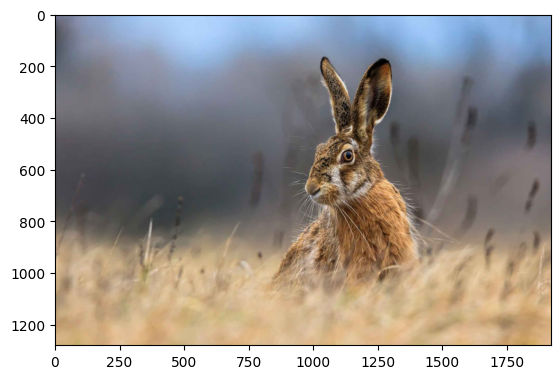

In [101]:
img = Image.open('zayac_rusak.jpg')
plt.imshow(img)

In [102]:
# Преобразования изображений на основе модуля V2

size = 224  # Целевой размер изображения после кадрирования (224x224 пикселя)

transform_v2 = v2.Compose([
    v2.ToImage(),            # 1. Конвертируем в тензор [C,H,W] (0-255)
    v2.Resize(256),          # 2. Изменяет размер изображения cохраняя пропорции так, чтобы меньшая сторона (ширина или высота) стала равна 256 пикселям
    v2.CenterCrop(size),     # 3. Вырезает центральную область размером 224x224 пикселя
    v2.ToDtype(              # 4. Конвертируем в float и делим на 255
        dtype=torch.float32, 
        scale=True
    ),
    v2.Normalize(            # 5. Нормализует тензор (нормализация ImageNet (на котором предобучены популярные модели)):
        mean=(0.485, 0.456, 0.406),  # Вычитает эти средние значения для каждого канала (RGB)
        std=(0.229, 0.224, 0.225)    # Делит на эти стандартные отклонения для каждого канала
    )
])

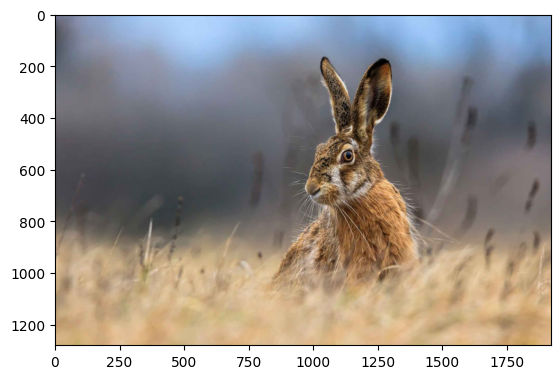

С вероятностью 43% на картинке изображен заяц.


In [123]:
x = transform_v2(img)
translator = Translator()

resnet_model.eval()
pred = resnet_model(x.unsqueeze(dim=0)).squeeze()  
sorted, indices = pred.softmax(dim=0).sort(descending=True) #sorted - отсортированные значения вероятностей, indices - индексы классов по убывания вероятности

result = translator.translate(
    text=str(class_names[indices[0].item()]),  # извлекаем индекс как число
    dest='ru'
)

plt.imshow(img)
plt.show()

print(f'С вероятностью {round(sorted[0].item() *100)}% на картинке изображен {result.text}.')